In [1]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoobi as scoobi



Jax available; Jax model can be used.
Succesfully initialized testbed interface.


In [19]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 500
scoobi.set_zwo_roi(xc, yc, npsf)

Succesfully initialized testbed interface.


In [57]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.zero_dm()

Succesfully initialized testbed interface.


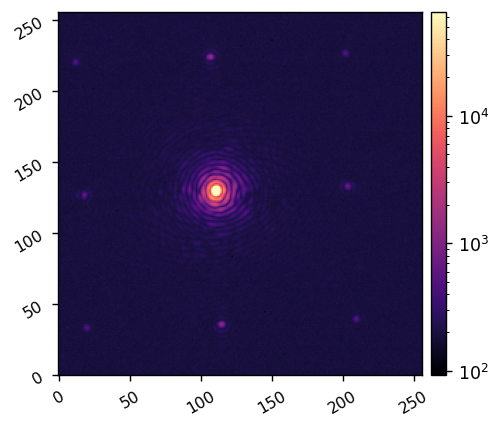

In [38]:
im = tbi.snap()
imshow1(im, lognorm=True)

# Do the normalization

In [33]:
scoobi.move_psf(50, 0)

3.19999999192078e-05

In [39]:
reload(scoobi)
scoobi.set_zwo_exp_time(0.00001)

Succesfully initialized testbed interface.


In [36]:
reload(scoobi)
scoobi.set_fib_atten(10)

Succesfully initialized testbed interface.


KeyError: 'No device fiberatten represented within these properties'

30606.4


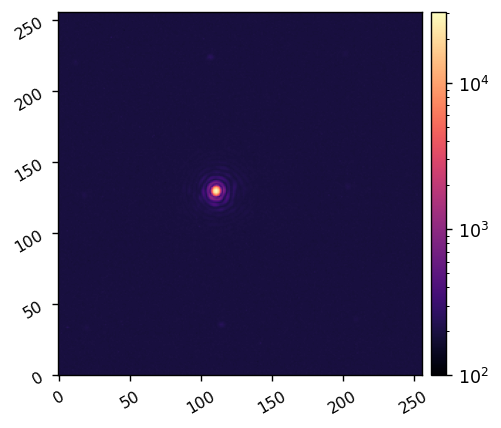

In [44]:
tbi.Nframes = 10
ref_psf = tbi.snap()
print(xp.max(im))
imshow1(im, lognorm=True, vmin=1e2)

In [53]:
reload(scoobi)
scoobi.get_zwo_exp_time()

Succesfully initialized testbed interface.


3.19999999192078e-05

In [89]:
10**((5 - 10)/10) 

0.31622776601683794

In [99]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.zero_dm()

Succesfully initialized testbed interface.


In [100]:
tbi.Imax_ref = xp.max(ref_psf)
tbi.att_ref = 10
tbi.texp_ref = 3.2e-5

In [103]:
scoobi.set_zwo_exp_time(0.005)

In [81]:
scoobi.move_psf(2, 0)

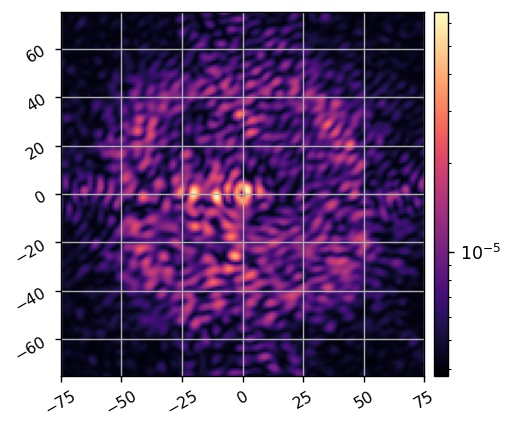

In [104]:
tbi.Nframes = 10
tbi.npsf = 150
tbi.x_shift = -3
tbi.y_shift = 0 

tbi.texp = scoobi.get_zwo_exp_time()
tbi.att = 0
tbi.return_ni = True

coro_im = tbi.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

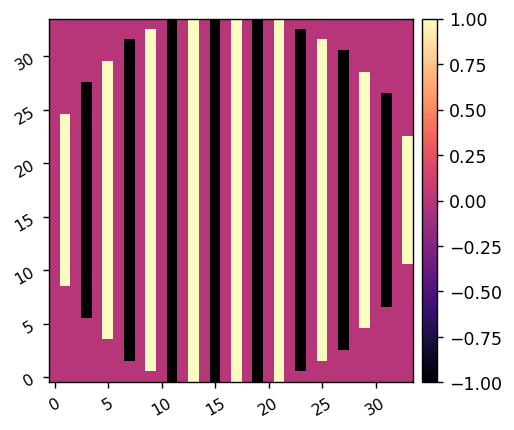

In [105]:
def create_sin_command(x_cpa=10, y_cpa=10, Nact=34):
    # cpa = cycles per aperture
    # max cpa must be Nact/2
    if x_cpa>Nact/2 or y_cpa>Nact/2:
        raise ValueError('The cycles per aperture is too high for the specified number of actuators.')
    y,x = xp.indices((Nact, Nact)) - Nact//2
    sin_command = xp.cos(2*np.pi*(x_cpa*x + y_cpa*y)/Nact)
    return sin_command

sin_command = create_sin_command(x_cpa=8.5, y_cpa=0) * xp.array(tbi.dm_mask)
imshow1(sin_command)


In [14]:
tbi.zero_dm()

In [106]:
tbi.set_dm(5e-9 * sin_command)

In [107]:
sin_im = tbi.snap()

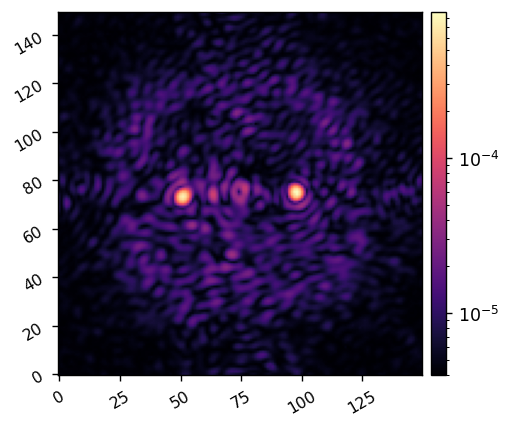

In [108]:
imshow1(sin_im, lognorm=True)

In [110]:
import skimage

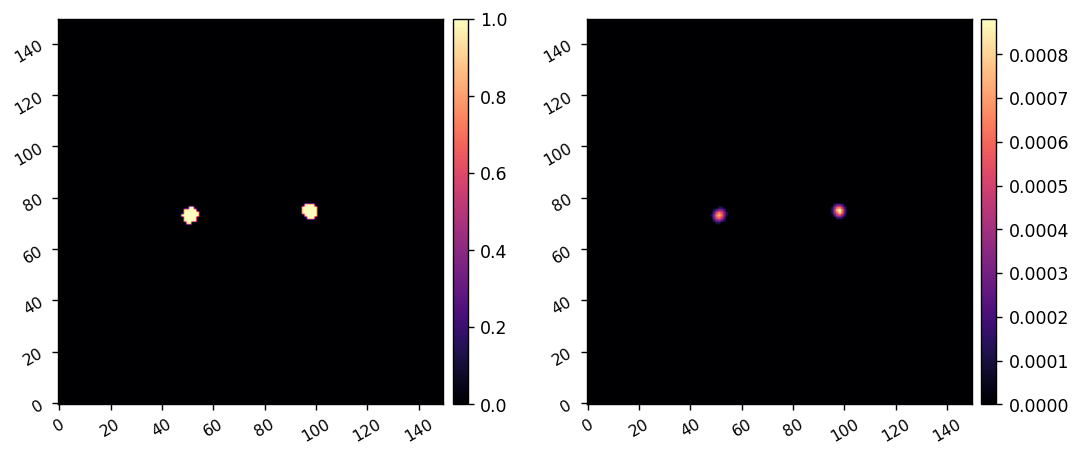

Centroids:
 [[51.04037545 73.04099463]
 [97.70365095 74.71420543]]


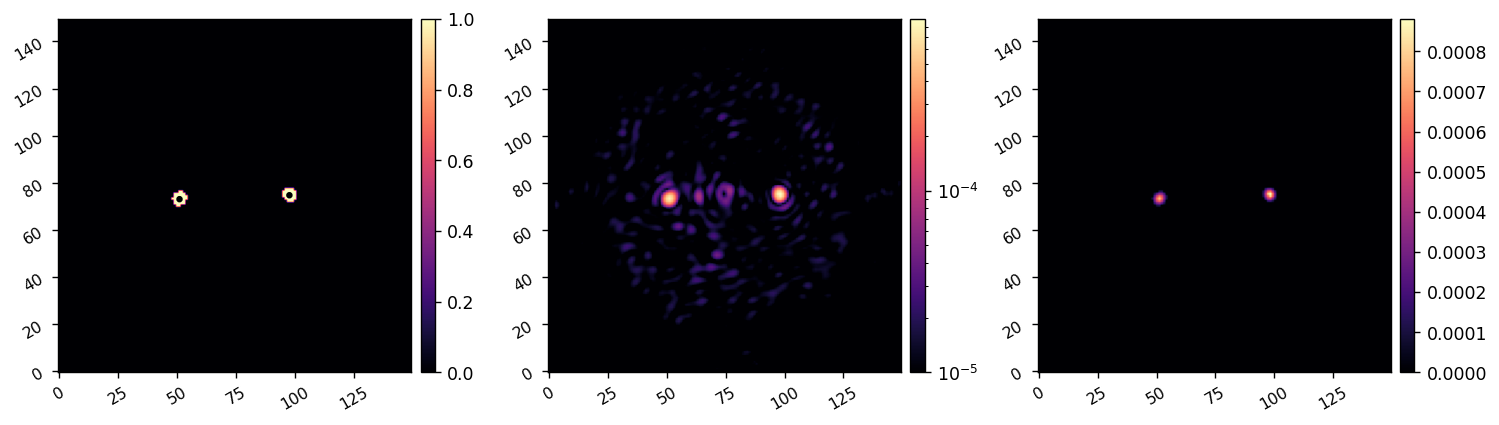

Pixelscale:
 0.30696790214767256


In [116]:
def measure_pixelscale(sin_im, cpa, 
                       dm_diam=10.2, dm_lyot_mag=9.4/9.4, lyot_diam=8.6, 
                       im_thresh=1e-4, r_thresh=20, 
                       verbose=True, plot=True,):
    npsf = sin_im.shape[0]
    y,x = (xp.indices((npsf, npsf)) - npsf//2)
    r = xp.sqrt(x**2 + y**2)
    sin_mask = (sin_im >im_thresh) * (r>r_thresh)
    imshow2(sin_mask, sin_mask*sin_im)

    centroids = []
    for i in [0,1]:
        arr = sin_im[:, i*npsf//2:(i+1)*npsf//2]
        mask = sin_mask[:, i*npsf//2:(i+1)*npsf//2]
        cent = np.flip(skimage.measure.centroid(ensure_np_array(mask*arr)))
        cent[0] += i*npsf//2
        centroids.append(cent)
        # print(cent)
        # imshow3(mask, arr, mask*arr, lognorm2=True,
        #         patches1=[Circle(cent, 1, fill=True, color='cyan')])
    centroids = np.array(centroids)
    if verbose: print('Centroids:\n', centroids)

    if plot: 
        patches = []
        for i in range(2):
            patches.append(Circle(centroids[i], 1, fill=True, color='black'))
        imshow3(sin_mask, sin_im, sin_mask*sin_im, lognorm2=True, vmin2=1e-5,
                patches1=patches)

    sep_pix = np.sqrt((centroids[1][0] - centroids[0][0])**2 + (centroids[1][1] - centroids[0][1])**2)
    pixelscale_lamD = (2*cpa) / sep_pix * lyot_diam/(dm_diam * dm_lyot_mag)
    if verbose: print('Pixelscale:\n', pixelscale_lamD)

    return pixelscale_lamD

pixelscale_lamD = measure_pixelscale(sin_im, cpa=8.5, im_thresh=1e-4, r_thresh=10)

In [124]:
tbi.psf_pixelscale_lamD = pixelscale_lamD

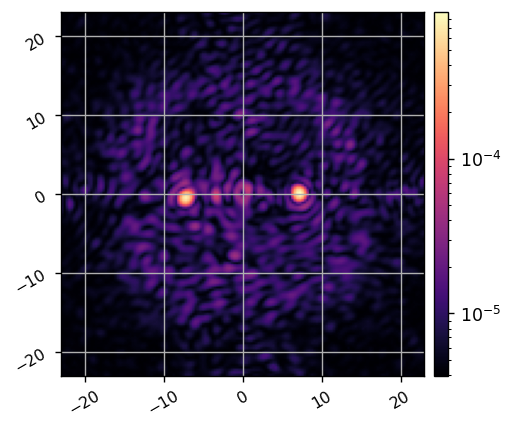

In [119]:
imshow1(sin_im, lognorm=True, pxscl=pixelscale_lamD, grid=True)

In [121]:
tbi.zero_dm()

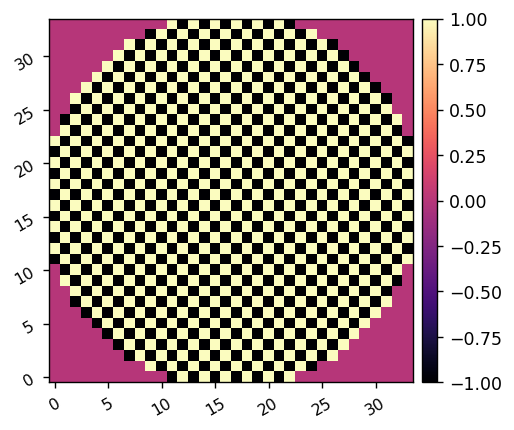

In [123]:
waffle_command = create_sin_command(x_cpa=17, y_cpa=17) * xp.array(tbi.dm_mask)
imshow1(waffle_command)

In [127]:
tbi.set_dm(10e-9 * waffle_command)

In [132]:
tbi.npsf = 150
waffle_im = tbi.snap()

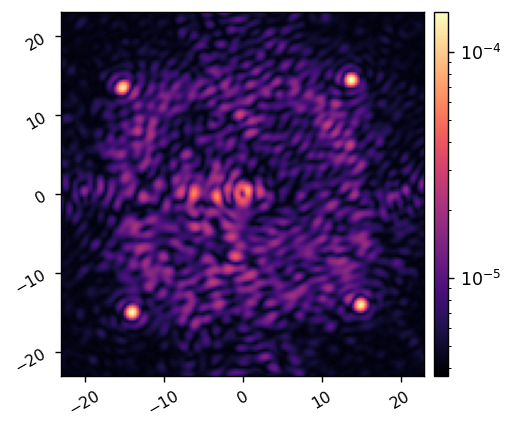

In [133]:
imshow1(waffle_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD)

Centroids:
 [[ 28.75737927  25.71702702]
 [ 24.98455157 118.47658552]
 [119.21811816 121.51408231]
 [123.0050286   28.86204377]
 [ 28.75737927  25.71702702]]


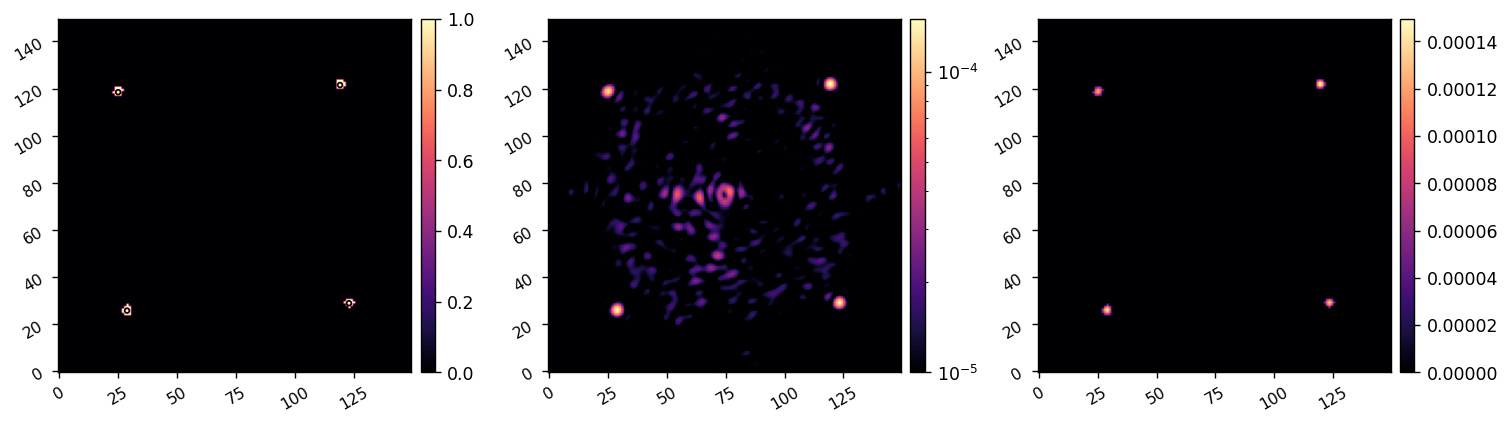

Angle:  87.89322955878923


In [139]:
def measure_detector_angle(waffle_im, psf_pixelscale_lamD, im_thresh=1e-4, r_thresh=12,
                           verbose=True, 
                           plot=True):
    npsf = waffle_im.shape[0]
    y,x = (xp.indices((npsf, npsf)) - npsf//2)*psf_pixelscale_lamD
    r = xp.sqrt(x**2 + y**2)
    waffle_mask = (waffle_im >im_thresh) * (r>r_thresh)

    centroids = []
    for i in [0,1]:
        for j in [0,1]:
            arr = waffle_im[j*npsf//2:(j+1)*npsf//2, i*npsf//2:(i+1)*npsf//2]
            mask = waffle_mask[j*npsf//2:(j+1)*npsf//2, i*npsf//2:(i+1)*npsf//2]
            cent = np.flip(skimage.measure.centroid(ensure_np_array(mask*arr)))
            cent[0] += i*npsf//2
            cent[1] += j*npsf//2
            centroids.append(cent)
            # print(cent)
            # imshow3(mask, arr, mask*arr, lognorm2=True,
            #         patches1=[Circle(cent, 1, fill=True, color='cyan')])
    centroids.append(centroids[0])
    centroids = np.array(centroids)
    centroids[[2,3]] = centroids[[3,2]]
    if verbose: print('Centroids:\n', centroids)

    if plot: 
        patches = []
        for i in range(4):
            patches.append(Circle(centroids[i], 1, fill=False, color='black'))
        imshow3(waffle_mask, waffle_im, waffle_mask*waffle_im, lognorm2=True, vmin2=1e-5,
                patches1=patches)

    mean_angle = 0.0
    for i in range(4):
        angle = np.arctan2(centroids[i+1][1] - centroids[i][1], centroids[i+1][0] - centroids[i][0]) * 180/np.pi
        if angle<0:
            angle += 360
        if 0<angle<90:
            angle = 90-angle
        elif 90<angle<180:
            angle = 180-angle
        elif 180<angle<270:
            angle = 270-angle
        elif 270<angle<360:
            angle = 360-angle
        mean_angle += angle/4
    if verbose: print('Angle: ', mean_angle)

    return mean_angle

angle = measure_detector_angle(waffle_im, tbi.psf_pixelscale_lamD, im_thresh=5e-5, r_thresh=15)

In [149]:
tbi.zero_dm()

# Choose modes and probes for iEFC

In [143]:
import lina

def create_control_mask(npsf, pxscl, iwa=3, owa=12, edge=None, rotation=0, centered=True):
    if centered:
        x = xp.linspace(-npsf/2, npsf/2-1, npsf)*pxscl
    else:
        x = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*pxscl
    x,y = xp.meshgrid(x,x)
    r = xp.hypot(x, y)
    control_mask = (r < owa) * (r > iwa)
    if edge is not None: control_mask *= (x > edge)

    control_mask = _scipy.ndimage.rotate(control_mask, rotation, reshape=False, order=0)
    return control_mask

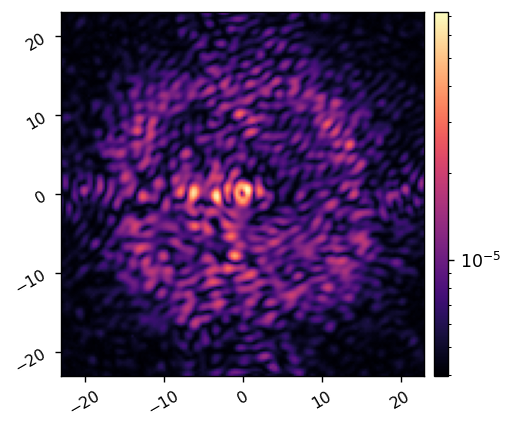

In [150]:
tbi.Nframes = 10
ref_coro_im = tbi.snap()
imshow1(ref_coro_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD)

7.710726906889066e-06


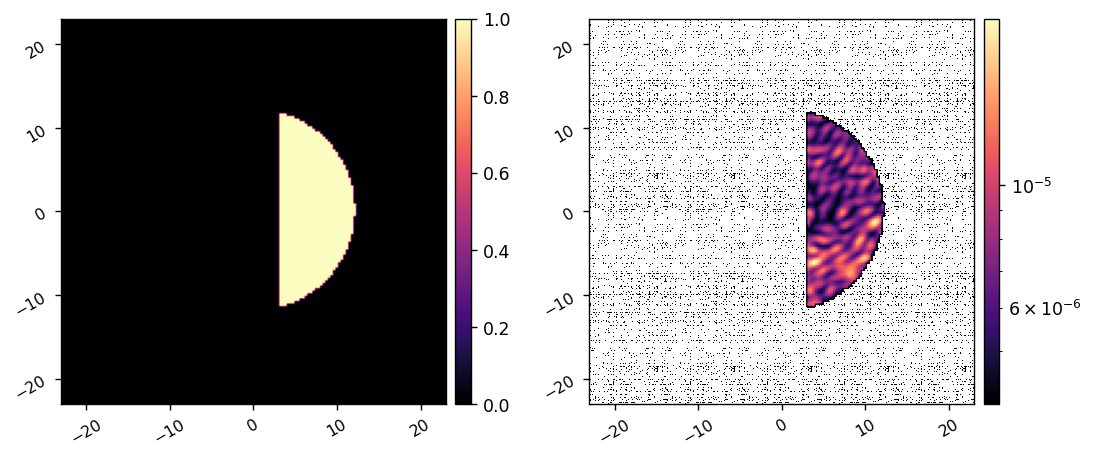

In [152]:
control_mask = create_control_mask(tbi.npsf, tbi.psf_pixelscale_lamD, iwa=3, owa=12, edge=3,)
print(xp.mean(ref_coro_im[control_mask]))
imshow2(control_mask, control_mask * ref_coro_im, lognorm2=True, pxscl=tbi.psf_pixelscale_lamD)

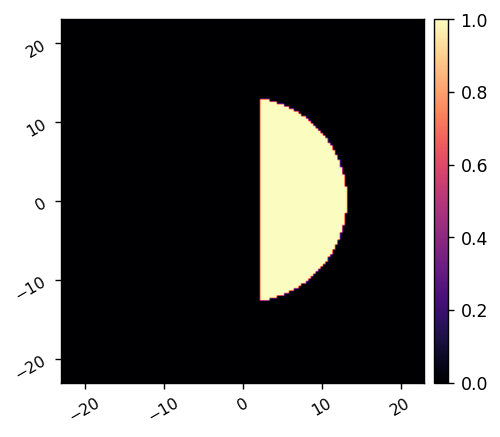

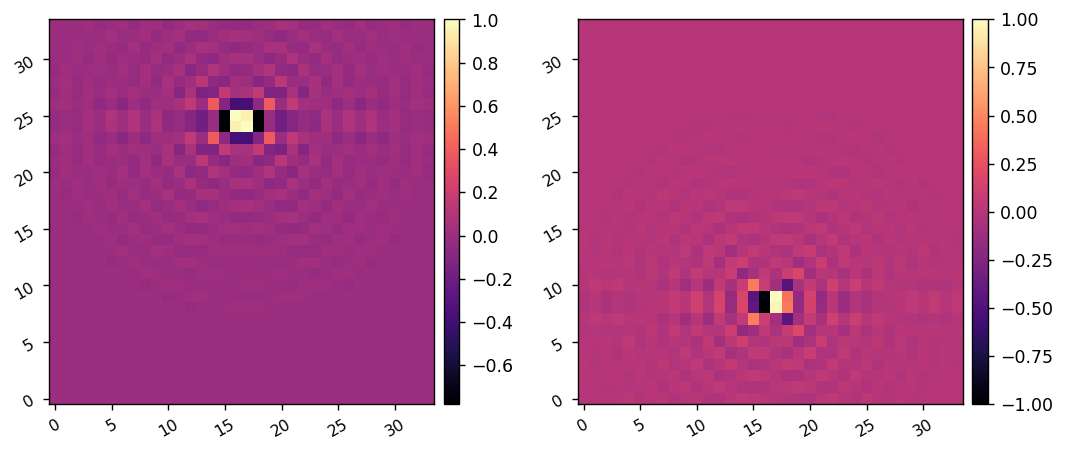

In [155]:
probe_iwa = 2
probe_owa = 13
probe_mask = create_control_mask(tbi.npsf, tbi.psf_pixelscale_lamD, probe_iwa, probe_owa, edge=2)
imshow1(probe_mask, pxscl=tbi.psf_pixelscale_lamD)
probe_modes = lina.utils.create_fourier_probes(tbi, probe_mask, fourier_sampling=0.25, 
                                               shift=[(0,8), (0,-8)], 
                                            #    shift=[(-5,6), (5,6), (0, -5)], 
                                               use_weighting=True,
                                               nprobes=2, 
                                               )
imshow2(probe_modes[0], probe_modes[1])
# imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

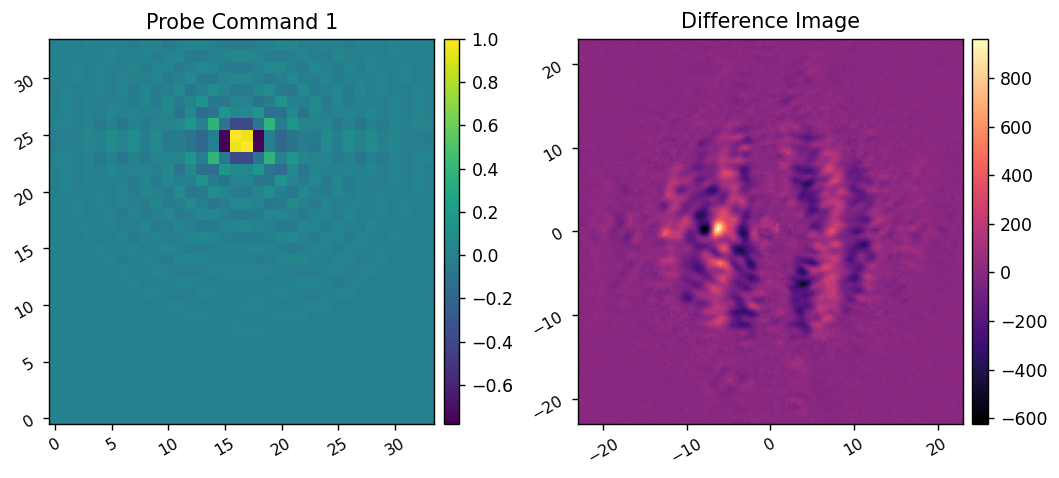

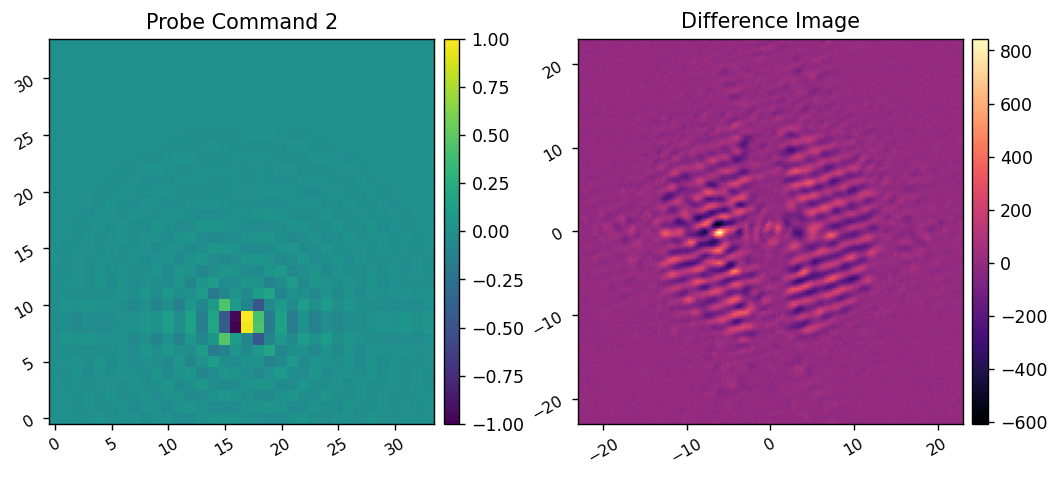

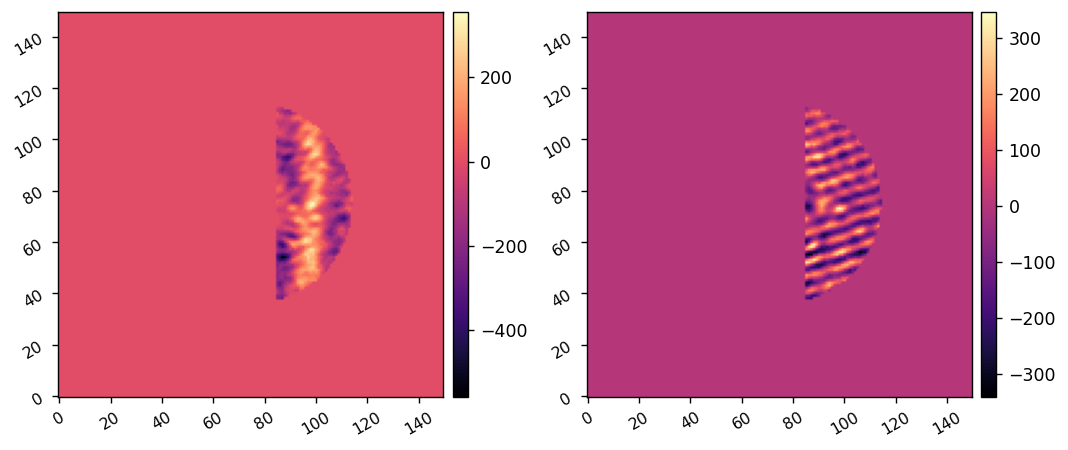

In [157]:
reload(lina.iefc)

diff_ims = lina.iefc.take_measurement(tbi, probe_modes, 5e-9, plot=True)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

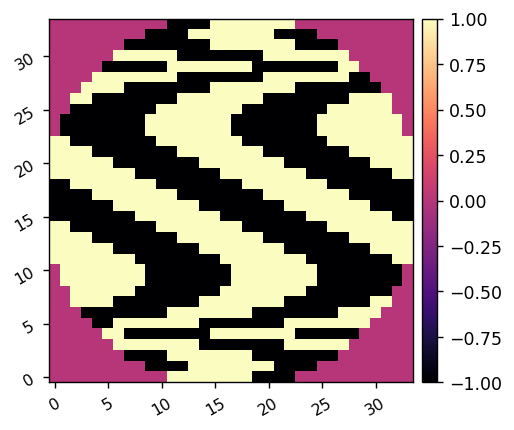

In [161]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(tbi.dm_mask))
imshow1(calib_modes[8].reshape(tbi.Nact, tbi.Nact))


In [174]:
tbi.zero_dm()

5.643150568791241e-06


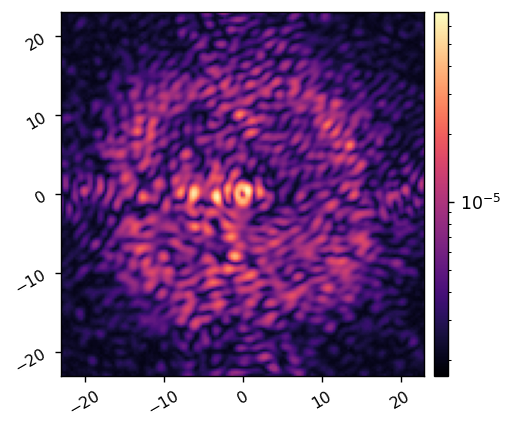

In [179]:
scoobi.set_zwo_exp_time(0.01)

tbi.texp = scoobi.get_zwo_exp_time()
tbi.Nframes = 3

coro_im = tbi.snap()
print(xp.mean(coro_im[control_mask]))
imshow1(coro_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD)

Calibrating iEFC...
	Calibrated mode 1024/1024 in 2424.585s
Calibration complete.


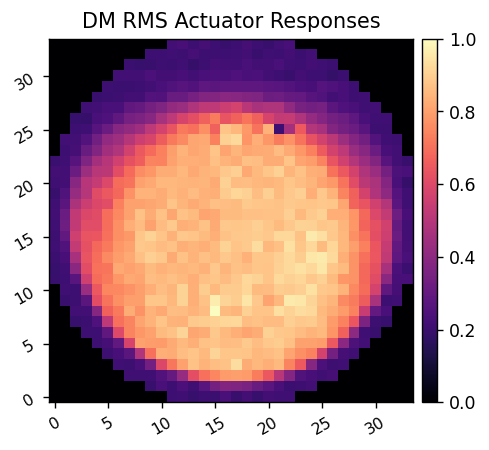

In [180]:
reload(lina.iefc)
tbi.zero_dm()

probe_amp = 5e-9
calib_amp = 5e-9

response_matrix, response_cube = lina.iefc.calibrate(tbi, control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, 
                                                     return_all=True,
                                                     )

In [181]:
lina.utils.save_fits('data/iefc_hadamard_jac.fits', response_matrix)

Saved data to:  data/iefc_hadamard_jac.fits


In [182]:
tbi.zero_dm()
all_ims = []
all_commands = []

In [200]:
scoobi.set_zwo_exp_time(0.05)

In [208]:
scoobi.client0.wait_for_properties(['scicam.emgain'])
scoobi.client0['scicam.emgain.target'] = 1

In [202]:
scoobi.client0.wait_for_properties(['scicam.emgain'])
scoobi.client0['scicam.emgain.target'] = 1
time.sleep(0.1)
im_1 = tbi.snap()

scoobi.client0.wait_for_properties(['scicam.emgain'])
scoobi.client0['scicam.emgain.target'] = 120
time.sleep(0.1)
im_120 = tbi.snap()

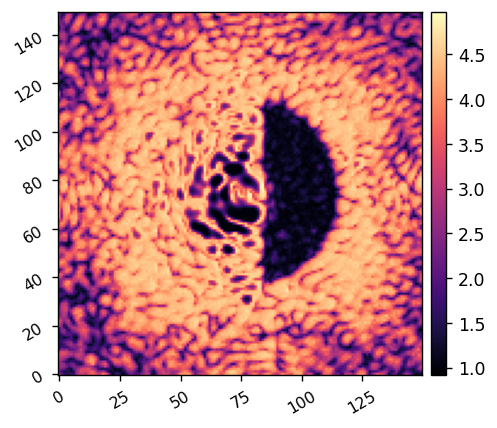

In [204]:
imshow1(im_120/im_1)

In [215]:
scoobi.set_zwo_exp_time(0.05)

4.7024196395800346e-07


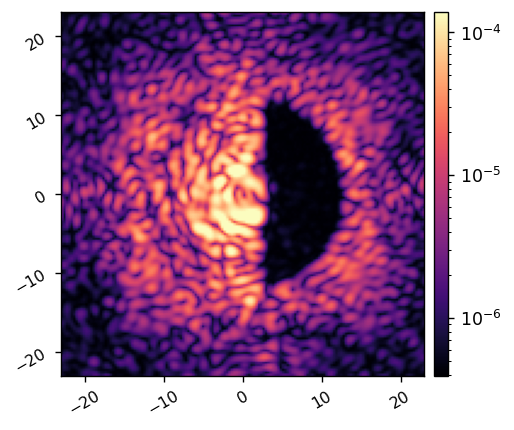

In [214]:
# scoobi.set_zwo_exp_time(0.05)

tbi.texp = scoobi.get_zwo_exp_time()
tbi.Nframes = 5

coro_im = tbi.snap()
print(xp.mean(coro_im[control_mask]))
imshow1(coro_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD)

Running iEFC...
	Closed-loop iteration 13 / 15


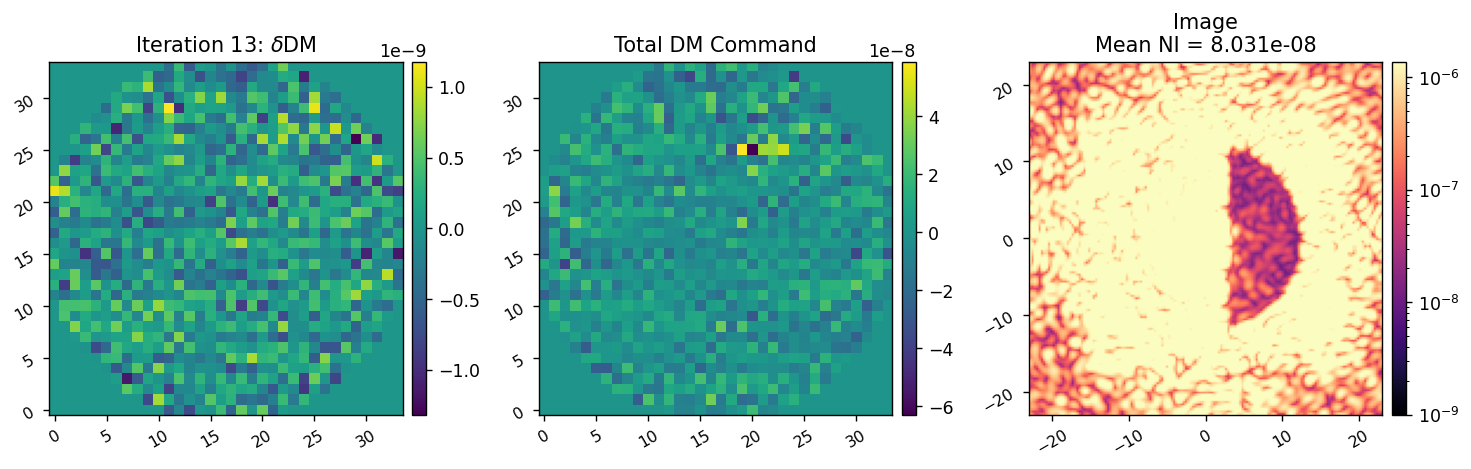

	Closed-loop iteration 14 / 15


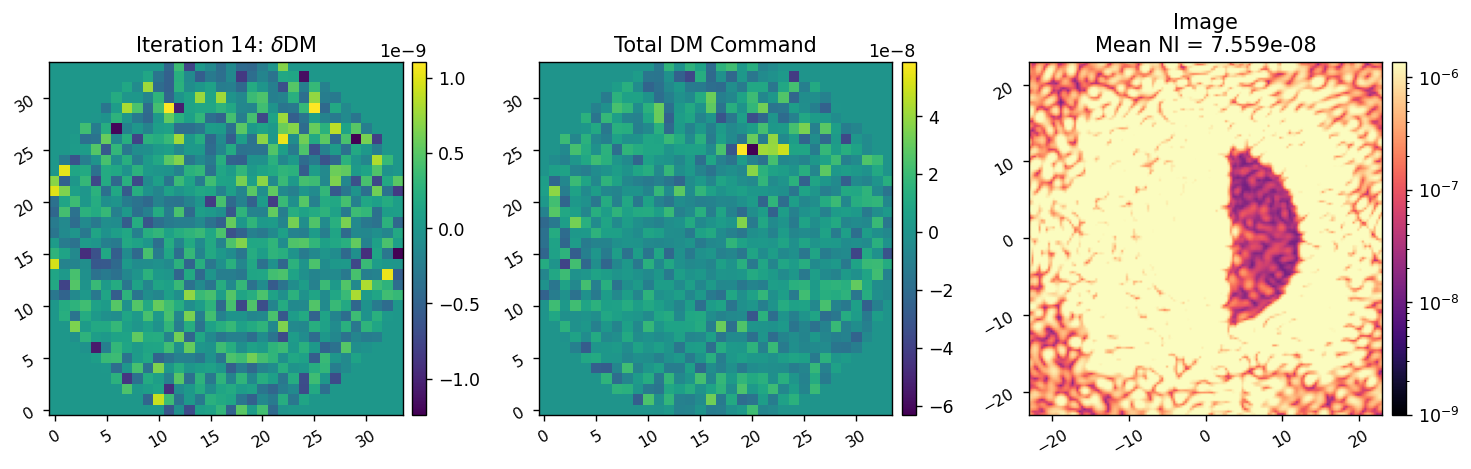

	Closed-loop iteration 15 / 15


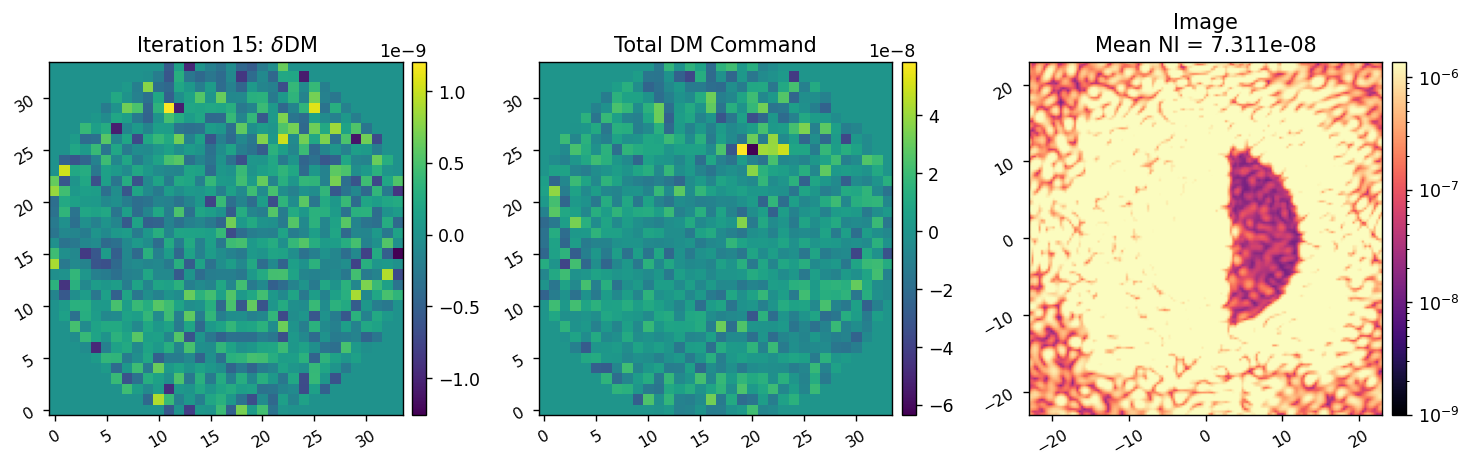

Closed loop for given control matrix completed in 153.265s.


In [198]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(response_matrix, -2.5)
# cm = lina.utils.beta_reg(response_matrix, -3.5)
# cm = lina.utils.beta_reg(response_matrix, -5)

probe_amp = 5e-9
probe_amp = 2.5e-9
# probe_amp = 1e-9

tbi.dm_delay = 0.5

all_ims, all_commands = lina.iefc.run(tbi,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims, 
                                        all_commands=all_commands,
                                        )

Running iEFC...
	Closed-loop iteration 7 / 9


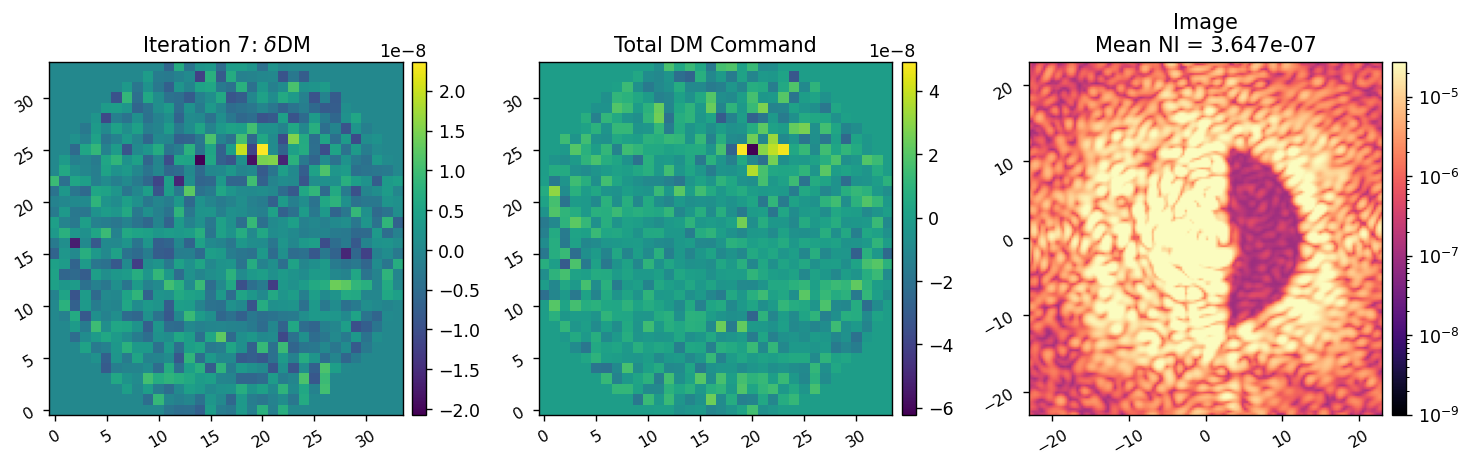

	Closed-loop iteration 8 / 9


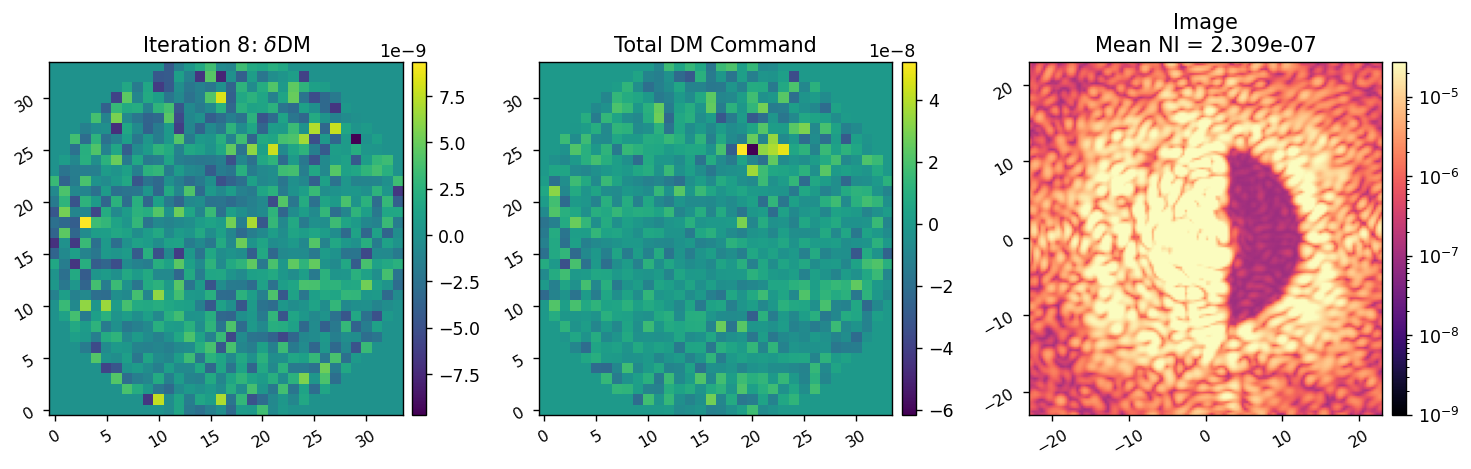

	Closed-loop iteration 9 / 9


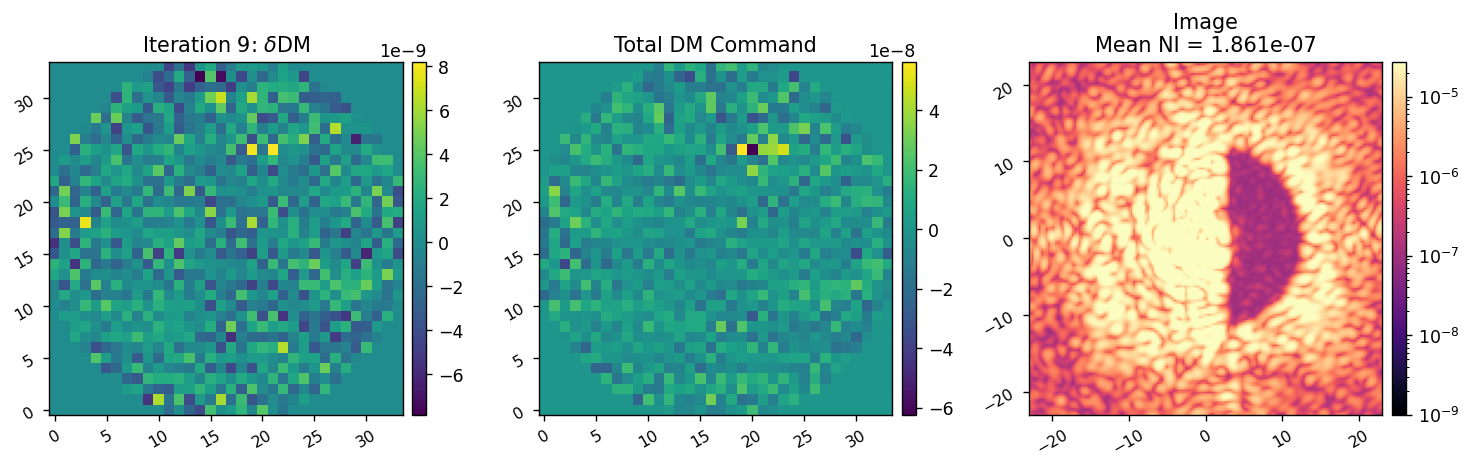

Closed loop for given control matrix completed in 86.565s.


In [192]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(response_matrix, -2.5)
cm = lina.utils.beta_reg(response_matrix, -5)

probe_amp = 5e-9
probe_amp = 2.5e-9
# probe_amp = 1e-9

tbi.dm_delay = 0.5

all_ims, all_commands = lina.iefc.run(tbi,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims, 
                                        all_commands=all_commands,
                                        )